In [1]:
import os
import sys
sys.path.append('./src') 
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt 
import numpy as np

from backbones import get_backbone
from denoiser import get_denoiser, Denoiser
from models import create_vae, AutoencoderKL, create_emar_model, EncoderMAR, \
    get_unmasked_indices, ICLContextEncoder

/home/haselab/anaconda3/envs/anomar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [186]:
category = "toothbrush"
num_inference_steps = 100
device = 'cuda'
num_samples = 1
start_step = 64

In [199]:
from torch.utils.data import DataLoader
import torch

normal_dataset = build_dataset(
    dataset_name='mvtec_ad',
    data_root = "data/mvtec_ad",
    train=True,
    img_size=224,
    transform_type="default",
    category = category,
    # normal_only = True
)
anom_dataset = build_dataset(
    dataset_name='mvtec_ad',
    data_root = "data/mvtec_ad",
    train=False,
    img_size=224,
    transform_type="default",
    category = category,
    anom_only = True
)

dummy_category = "hazelnut"
dummy_dataset = build_dataset(
    dataset_name='mvtec_ad',
    data_root = "data/mvtec_ad",
    train=True,
    img_size=224,
    transform_type="default",
    category = dummy_category,
    # normal_only = True
)
print(len(normal_dataset))
print(len(anom_dataset))
print(len(dummy_dataset))

60
30
391


In [200]:
log_dir = f"./results/exp_icl_ca_vae_exbottle_enc"
config_path = os.path.join(log_dir, "config.yaml")
ckpt_path = os.path.join(log_dir, "model_latest.pth")
encoder_ckpt_path = os.path.join(log_dir, "encoder_latest.pth")

with open(config_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

seed = config['meta']['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
img_size = config['data']['img_size']
device = device
num_samples = num_samples

# build backbone model
if 'vae' in config['backbone']['model_type']:
    backbone = create_vae(**config['backbone'])
else:
    backbone = get_backbone(**config['backbone'])
backbone.to(device).eval()

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from ./weights/vae/kl16.ckpt


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [201]:
backbone_embed_dim = config['backbone']['embed_dim']
backbone_stride = config['backbone']['stride']
img_size = config['data']['img_size']
mim_in_sh = (backbone_embed_dim, img_size // backbone_stride, img_size // backbone_stride)

model: Denoiser = get_denoiser(**config['diffusion'], input_shape=mim_in_sh)
model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)
encoder = ICLContextEncoder(**config['encoder'])
encoder_ckpt = torch.load(encoder_ckpt_path, map_location='cpu', weights_only=True)
results = model.load_state_dict(model_ckpt, strict=False)
enc_results = encoder.load_state_dict(encoder_ckpt, strict=False)
print(results)
print(enc_results)
model.to(device).eval()
encoder.to(device).eval()   

<All keys matched successfully>
<All keys matched successfully>


ICLContextEncoder(
  (in_proj): Linear(in_features=16, out_features=256, bias=True)
  (pos_embed): PosEmbedding()
  (blocks): ModuleList(
    (0-3): 4 x ModuleList(
      (0): MultiHeadAttentionBlock(
        (to_qkv): Linear(in_features=256, out_features=768, bias=False)
        (to_out): Linear(in_features=256, out_features=256, bias=True)
      )
      (1): FeedForwardBlock(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
    )
  )
  (out_proj): Linear(in_features=256, out_features=16, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [202]:
from mask import RandomMaskCollator, BlockRandomMaskCollator, CheckerBoardMaskCollator, SlidingWindowMaskCollator, indices_to_mask, mask_to_indices
from datasets import EvalDataLoader
mask_strategy = config['data']['mask']['strategy']

# mask_ratio = conf ig['data']['mask']['ratio']
mask_ratio = 0.75
patch_size = 1
if mask_strategy == "random":
    mask_collator = RandomMaskCollator(
        ratio=mask_ratio, input_size=mim_in_sh[1], patch_size=patch_size, min_ratio=mask_ratio, max_ratio=mask_ratio
    )
elif mask_strategy == "block":
    mask_collator = BlockRandomMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, mask_ratio=mask_ratio, **config['data']['mask']
    )
elif mask_strategy == "checkerboard":
    mask_collator = CheckerBoardMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, **config['data']['mask']
    )
elif mask_strategy == "sliding_window":
    mask_collator = SlidingWindowMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, **config['data']['mask']
    )
else:
    raise ValueError(f"Invalid mask strategy: {mask_strategy}")

bs = 8

# normal_dataloader = EvalDataLoader(normal_dataset, num_repeat=bs, collate_fn=mask_collator)
# anom_dataloader = EvalDataLoader(anom_dataset, num_repeat=bs, collate_fn=mask_collator)
normal_dataloader = DataLoader(normal_dataset, batch_size=bs, shuffle=False, num_workers=4, collate_fn=mask_collator, drop_last=False)
anom_dataloader = DataLoader(anom_dataset, batch_size=bs, shuffle=False, num_workers=4, collate_fn=mask_collator, drop_last=False)
dummy_dataloader = DataLoader(dummy_dataset, batch_size=bs, shuffle=False, num_workers=4, collate_fn=mask_collator, drop_last=False)

In [203]:
# batch, mask_indices = list(iter(normal_dataloader))[20]
batch, mask_indices = next(iter(normal_dataloader))
dummy_batch, _ = next(iter(dummy_dataloader))
# ensure same mask for all samples
mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

mask = indices_to_mask(mask_indices, mim_in_sh[1]*mim_in_sh[2])
mask = mask.to(device)

mask_indices = mask_indices.to(device)
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)
# gt_masks = batch["masks"]  # (B, 1, H, W) 
paths = batch["filenames"]
dummy_images = dummy_batch["samples"].to(device)
print(paths)

['data/mvtec_ad/toothbrush/train/good/000.png', 'data/mvtec_ad/toothbrush/train/good/001.png', 'data/mvtec_ad/toothbrush/train/good/002.png', 'data/mvtec_ad/toothbrush/train/good/003.png', 'data/mvtec_ad/toothbrush/train/good/004.png', 'data/mvtec_ad/toothbrush/train/good/005.png', 'data/mvtec_ad/toothbrush/train/good/006.png', 'data/mvtec_ad/toothbrush/train/good/007.png']


In [204]:
from einops import rearrange

@torch.no_grad()
def encode_images(x):
    if 'vae' in config['backbone']['model_type']:
        post = backbone.encode(x)
        return post.sample().mul_(0.2325)
    else:
        return backbone(x)

def rollout(x):
    # Rollout -> (B, B, c, h, w)
    # We assume the first element is target to masked image prediction
    # and the rest are for the context images
    # [[x_0, x_1, ..., x_B], [x_1, x_2, ..., x_B, x_0], ..., [x_B, x_0, ..., x_B-1]]
    B = x.shape[0]
    rolled_x = torch.stack([torch.roll(x, -i, dims=1) for i in range(B)])
    rolled_x = rearrange(rolled_x, "b1 b2 c h w -> b1 b2 (h w) c")
    return rolled_x

def perturb(z, t, denoiser: Denoiser):
    z = z.repeat_interleave(num_samples, dim=0)  # (B*K, M, c*p*p)
    noised_z = denoiser.q_sample(z, t)  # (B*K, M, c*p*p)
    return noised_z, z
    
@torch.no_grad()
def decode_images(x):
    if 'vae' in config['backbone']['model_type']:
        return backbone.decode(x / 0.2325)
    else:
        raise ValueError(f"Backbone {config['backbone']['model_type']} does not support decoding")

def reshape_mask(m):  
    """ (B, hw) -> (B, hp, wp) """
    m = rearrange(m, 'b (h w) -> b h w', h=mim_in_sh[1], w=mim_in_sh[2])
    m = torch.repeat_interleave(m, repeats=patch_size, dim=1)
    m = torch.repeat_interleave(m, repeats=patch_size, dim=2)
    m = m.float()
    return m

In [205]:
with torch.no_grad():
    # 1. Extract features
    latents = encode_images(images)  # (B, c, h, w)
    dummy_latents = encode_images(dummy_images)
    rolled_latents = rollout(latents)  # (B, B, c, h, w)
    rolled_dummy_latents = rollout(dummy_latents)

    # 2. Get model inputs
    # condition: (B, B-1, N, C)
    # target: (B, M, C)
    # cond = rolled_latents[:, 1:, ...]  # (B, B-1, c, h, w)
    cond = rolled_dummy_latents[:, 1:, ...]  # (B, B-1, c, h, w)
    cond, _ = encoder(cond)
    cond = cond.unsqueeze(1)
    # cond = torch.rand_like(cond)  # random context
    
    target = rearrange(latents.clone().detach(), "b c h w -> b (h w) c")
    target_dummy = rearrange(dummy_latents.clone().detach(), "b c h w -> b (h w) c")
    
    masked_target = torch.gather(target, 1, mask_indices.unsqueeze(-1).expand(-1, -1, target.size(-1)))
    masked_target_dummy = torch.gather(target_dummy, 1, mask_indices.unsqueeze(-1).expand(-1, -1, target.size(-1)))
    
    unmasked_indices = get_unmasked_indices(mask_indices, target.size(1))
    unmasked_target = torch.gather(target, 1, unmasked_indices.unsqueeze(-1).expand(-1, -1, target.size(-1)))
    unmasked_target_dummy = torch.gather(target_dummy, 1, unmasked_indices.unsqueeze(-1).expand(-1, -1, target.size(-1)))
    
    # 3. Calculate loss 
    loss = model(masked_target, z=cond, mask_indices=mask_indices, z_vis=unmasked_target_dummy)
    print(f"Loss: {loss.item()}")
    
# 2. Denoising on masked tokens
t = torch.tensor([start_step] * num_samples * len(images)).to(device)

noised_targets, org_targets = perturb(masked_target, t, model)  # (B*K, M, c*p*p)

Loss: 0.37245458364486694


In [206]:
@torch.no_grad()
def denoising(model, noised_z, t, cond, mask_indices, z_vis):
    cond = cond.repeat_interleave(num_samples, dim=0)  # (B*K, M, c*p*p)
    # cond = torch.zeros_like(cond)  # (B*K, M, c*p*p)
    mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
    denoized_z = model.denoise_from_intermediate(noised_z, t, z=cond, mask_indices=mask_indices, z_vis=z_vis)  # (B*K, M, c*p*p)
    return denoized_z

@torch.no_grad()
def sample(model, input_shape, cond, mask_indices, z_vis):
    cond = cond.repeat_interleave(num_samples, dim=0)  # (B*K, M, c*p*p)
    mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
    sample = model.sample(input_shape, z=cond, mask_indices=mask_indices, z_vis=z_vis)  # (B*K, M, c*p*p)
    return sample
    
# preds = denoising(model, noised_targets, t, cond, mask_indices, )  # (B*K, M, c*p*p)
preds = sample(model, noised_targets.shape[1:], cond, mask_indices, unmasked_target)  # (B*K, M, c*p*p)

In [207]:
mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
l = rearrange(latents, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', h=mim_in_sh[1], w=mim_in_sh[2], p1=patch_size, p2=patch_size)
l = l.repeat_interleave(num_samples, dim=0)  # (B*K, N, c)
pred_l = l.clone()
pred_l[torch.arange(len(pred_l)).unsqueeze(1), mask_indices] = preds  # (B*K, N, c)
pred_l_map = rearrange(pred_l, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)

In [208]:
from torch.nn import functional as F

def postprocess(x):
    x = x / 2 + 0.5
    return x.clamp(0, 1)

def convert2image(x):
    if x.dim() == 3:
        return x.permute(1, 2, 0).cpu().numpy()
    elif x.dim() == 4:
        return x.permute(0, 2, 3, 1).cpu().numpy()
    else:
        return x.cpu().numpy()

pred_imgs = decode_images(pred_l_map)  # (B*K, 3, H, W)
m = reshape_mask(mask).unsqueeze(1)  # (B, H, W)
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
m = F.interpolate(m, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
masked_imgs = convert2image(postprocess(images) * (1 - m))  # (B, H, W, C)
pred_imgs = convert2image(postprocess(pred_imgs)) # (B*K, H, W, C)
pred_imgs = pred_imgs.reshape(-1, num_samples, *pred_imgs.shape[1:]) # (B, K, H, W, C)  

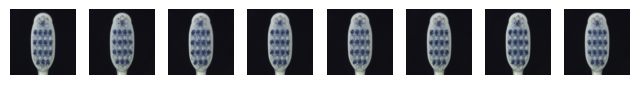

In [209]:
# Plot all context images
fig, axs = plt.subplots(1, bs, figsize=(8, 32))

for i in range(bs):
    axs[i].imshow(org_imgs[i])
    axs[i].axis('off')

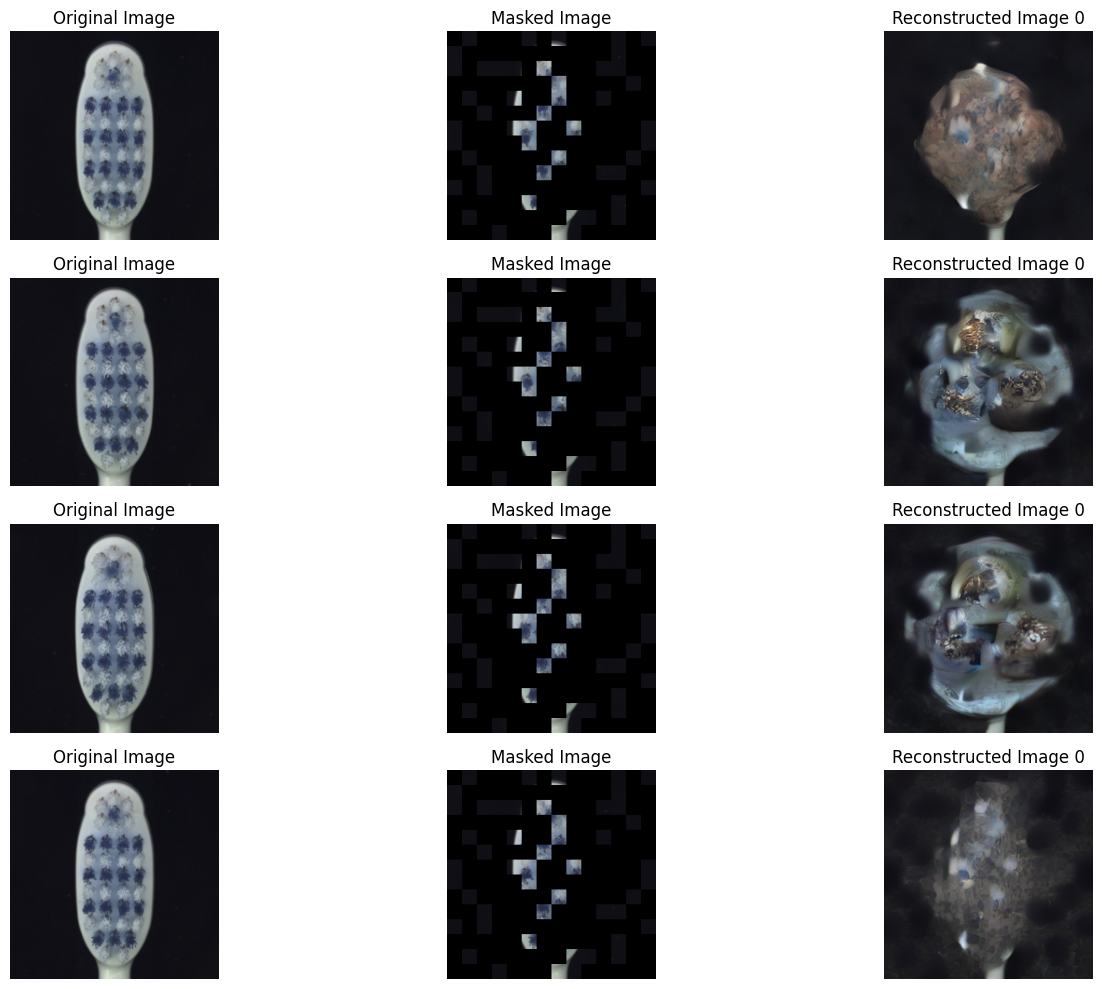

In [210]:
# Plot reconstruction
org_img = org_imgs[3]
masked_img = masked_imgs[3]
pred_img = pred_imgs[3]  # (K, H, W, C)

# fig, ax = plt.subplots(1, 2 + num_samples, figsize=(15, 5))
# ax[0].imshow(org_img)
# ax[0].set_title("Original Image")
# ax[0].axis('off')
# ax[1].imshow(masked_img)
# ax[1].set_title("Masked Image")
# ax[1].axis('off')
# ax[2].imshow(pred_img[0])
# ax[2].set_title("Reconstructed Image 0")
# ax[2].axis('off')
# for i in range(num_samples-1):
#     ax[3 + i].imshow(pred_img[i+1])
#     ax[3 + i].set_title(f"Reconstructed Image {i+1}")
#     ax[3 + i].axis('off')

fig, ax = plt.subplots(4, 2 + num_samples, figsize=(15, 10))
for i in range(4):
    ax[i, 0].imshow(org_imgs[i])
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis('off')
    ax[i, 1].imshow(masked_imgs[i])
    ax[i, 1].set_title("Masked Image")
    ax[i, 1].axis('off')
    for j in range(num_samples):
        ax[i, 2 + j].imshow(pred_imgs[i, j])
        ax[i, 2 + j].set_title(f"Reconstructed Image {j}")
        ax[i, 2 + j].axis('off')

plt.tight_layout()
plt.show()

In [109]:
# Plot reconstruction of MIM
batch, mask_indices = next(iter(anom_dataloader))
# ensure same mask for all samples
mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

mask = indices_to_mask(mask_indices, model.num_patches)
mask = mask.to(device)

with torch.no_grad():
    latents = encode_images(images)
    outputs = model.masked_forward(latents, mask)  # (B)
    cond, target = outputs['preds'], outputs['targets']  # (B, M, c*p*p)

cond = torch.repeat_interleave(cond, repeats=num_samples, dim=0)  # (B*K, M, c*p*p)
mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
latents = rearrange(latents, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', h=mim_in_sh[1], w=mim_in_sh[2], p1=patch_size, p2=patch_size)
latents = latents.repeat_interleave(num_samples, dim=0)  # (B*K, N, c)
pred_latents = latents.clone()
pred_latents[torch.arange(len(pred_latents)).unsqueeze(1), mask_indices] = cond  # (B*K, N, c)
pred_latents_map = rearrange(pred_latents, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)

KeyError: 'preds'

In [239]:
pred_imgs = decode_images(pred_latents_map)  # (B*K, 3, H, W)
mask = reshape_mask(mask).unsqueeze(1)  # (B, H, W)
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
masked_imgs = convert2image(postprocess(images) * (1 - mask))  # (B, H, W, C)
pred_imgs = convert2image(postprocess(pred_imgs)) # (B*K, H, W, C)
pred_imgs = pred_imgs.reshape(-1, num_samples, *pred_imgs.shape[1:]) # (B, K, H, W, C)  

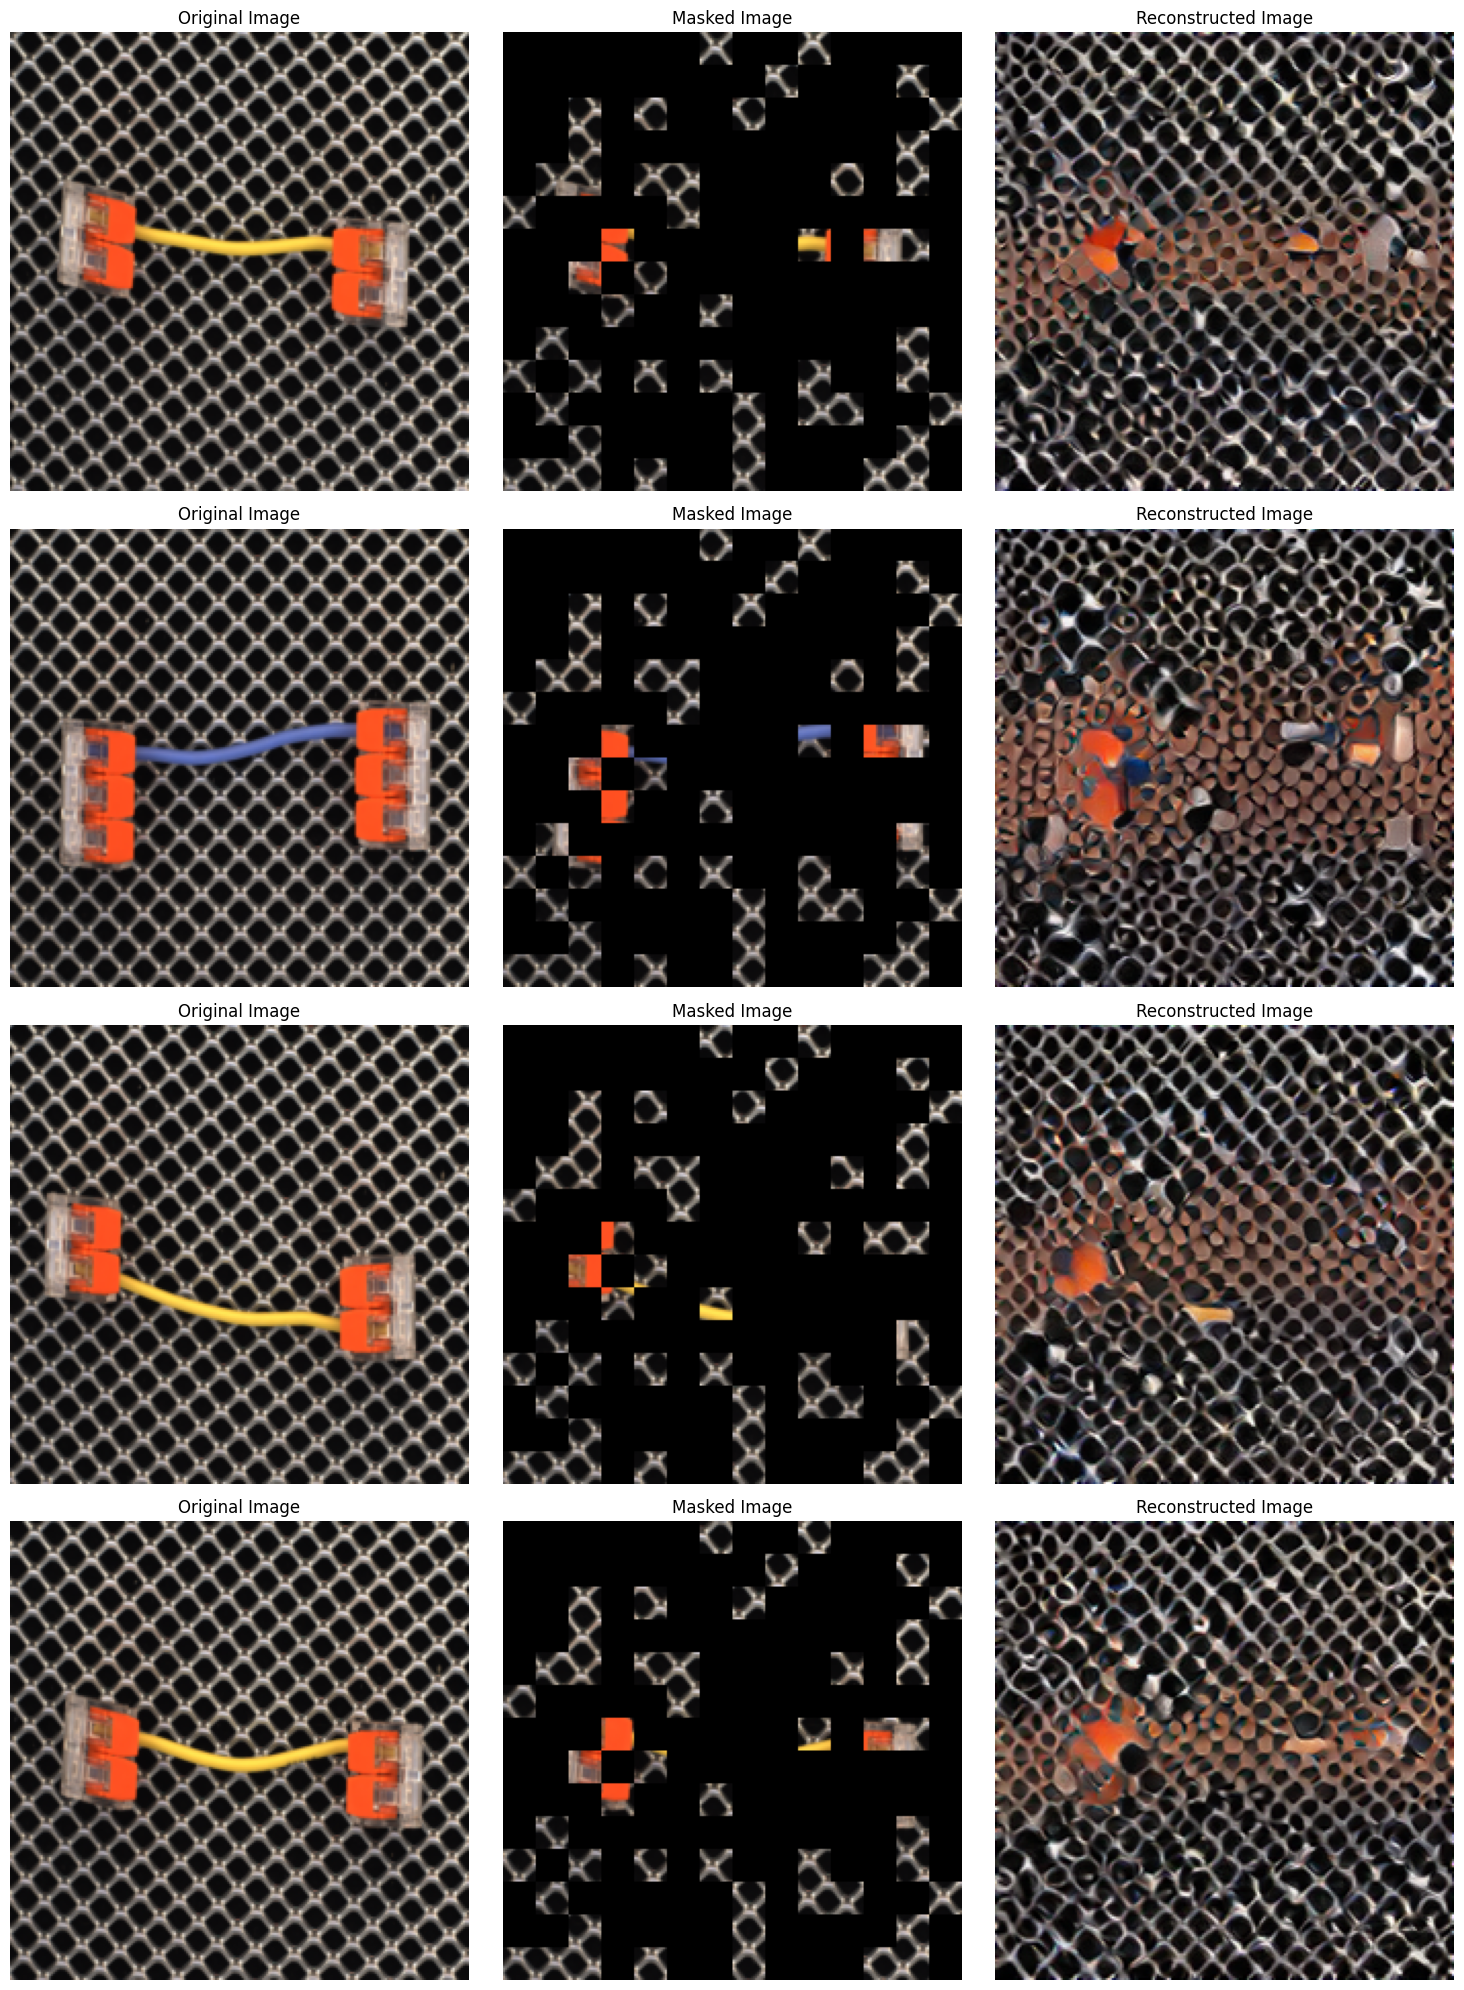

In [240]:
# Plot reconstruction
org_img = org_imgs[0]
masked_img = masked_imgs[0]
pred_img = pred_imgs[0]  # (K, H, W, C)

B = len(org_imgs)
fig, ax = plt.subplots(B, 3, figsize=(15, 5 * B))
for i in range(B):
    ax[i, 0].imshow(org_imgs[i])
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis('off')
    ax[i, 1].imshow(masked_imgs[i])
    ax[i, 1].set_title("Masked Image")
    ax[i, 1].axis('off')
    ax[i, 2].imshow(pred_imgs[i, 0])
    ax[i, 2].set_title(f"Reconstructed Image")
    ax[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Sensitivity Analysis

In [61]:
batch, mask_indices = next(iter(normal_dataloader))
# ensure same mask for all samples
mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

mask = indices_to_mask(mask_indices, model.num_patches)
mask = mask.to(device)

mask_indices = mask_indices.to(device)
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)
gt_masks = batch["masks"]  # (B, 1, H, W)

In [69]:
# Check if the conditioning is replaced with random vectors, how the denoiser's output changes
with torch.no_grad():
    latents = encode_images(images)
    outputs = model.masked_forward(latents, mask)  # (B)
    cond, target = outputs['preds'], outputs['targets']  # (B, M, c*p*p)

tensor([7.3997e+00, 6.1344e+00, 7.9649e+00, 4.0715e+00, 6.8579e+00, 1.1996e+00,
        1.3041e+01, 5.9994e+00, 1.7877e+01, 9.3736e+00, 4.3048e+00, 7.6533e+00,
        2.3447e+01, 1.5742e+01, 1.7795e+00, 1.2534e+00, 2.0759e+01, 1.6886e+01,
        2.5114e+00, 3.3506e+00, 7.3536e+00, 2.5192e+01, 8.2612e+00, 1.8247e+01,
        2.7488e+00, 3.6832e+01, 3.6919e+01, 9.4660e+00, 2.0171e+01, 3.5082e+01,
        6.9157e+00, 7.5813e+00, 5.9344e+00, 2.1594e+01, 5.4776e+00, 6.0661e+00,
        1.0813e+01, 2.0115e+01, 1.8854e+01, 5.1064e+00, 1.2394e+00, 3.4630e-02,
        3.7164e-02, 3.5049e-02, 3.4985e-02, 3.7160e-02, 3.6681e-02, 3.7664e-02,
        3.7289e-02, 3.4818e-02, 3.4158e-02, 3.5831e-02, 3.4815e-02, 3.5726e-02,
        3.5234e-02, 3.4344e-02, 3.4664e-02, 3.3294e-02, 3.7911e-02, 3.9856e-02,
        3.4925e-02, 3.7183e-02, 3.5495e-02, 3.4479e-02, 3.4375e-02, 3.4617e-02,
        3.6521e-02, 3.3274e-02, 3.4272e-02, 3.6199e-02, 3.3574e-02, 3.8148e-02,
        3.5918e-02, 3.3428e-02, 3.6392e-

In [57]:
# Check if the conditioning is replaced with random vectors, how the denoiser's output changes
with torch.no_grad():
    latents = encode_images(images)
    outputs = model.masked_forward(latents, mask)  # (B)
    cond, target = outputs['preds'], outputs['targets']  # (B, M, c*p*p)

pseudo_cond = cond.clone()# torch.randn_like(cond)  # (B, M, c*p*p)    
noised_targets, org_targets = perturb(target, t)  # (B*K, M, c*p*p)

preds = denoising(noised_targets, t, labels, cond, mask_indices)  # (B*K, M, c*p*p)
pseudo_preds = denoising(noised_targets, t, labels, pseudo_cond, mask_indices)  # (B*K, M, c*p*p)

mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
latents = rearrange(latents, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', h=mim_in_sh[1], w=mim_in_sh[2], p1=patch_size, p2=patch_size)
latents = latents.repeat_interleave(num_samples, dim=0)  # (B*K, N, c)

pred_latents = latents.clone()
pred_latents[torch.arange(len(pred_latents)).unsqueeze(1), mask_indices] = preds  # (B*K, N, c)
pseudo_pred_latents = latents.clone()
pseudo_pred_latents[torch.arange(len(pseudo_pred_latents)).unsqueeze(1), mask_indices] = pseudo_preds  # (B*K, N, c)

pred_latents_map = rearrange(pred_latents, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)
pseudo_pred_latents_map = rearrange(pseudo_pred_latents, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)

In [58]:
# Calculate the difference between the denoised output and the pseudo-denoised output
diff = torch.norm(pseudo_pred_latents - pred_latents, dim=-1)  # (B*K, M)
diff = diff.mean()  # (B*K)
print(diff)

tensor(1.7290, device='cuda:0')


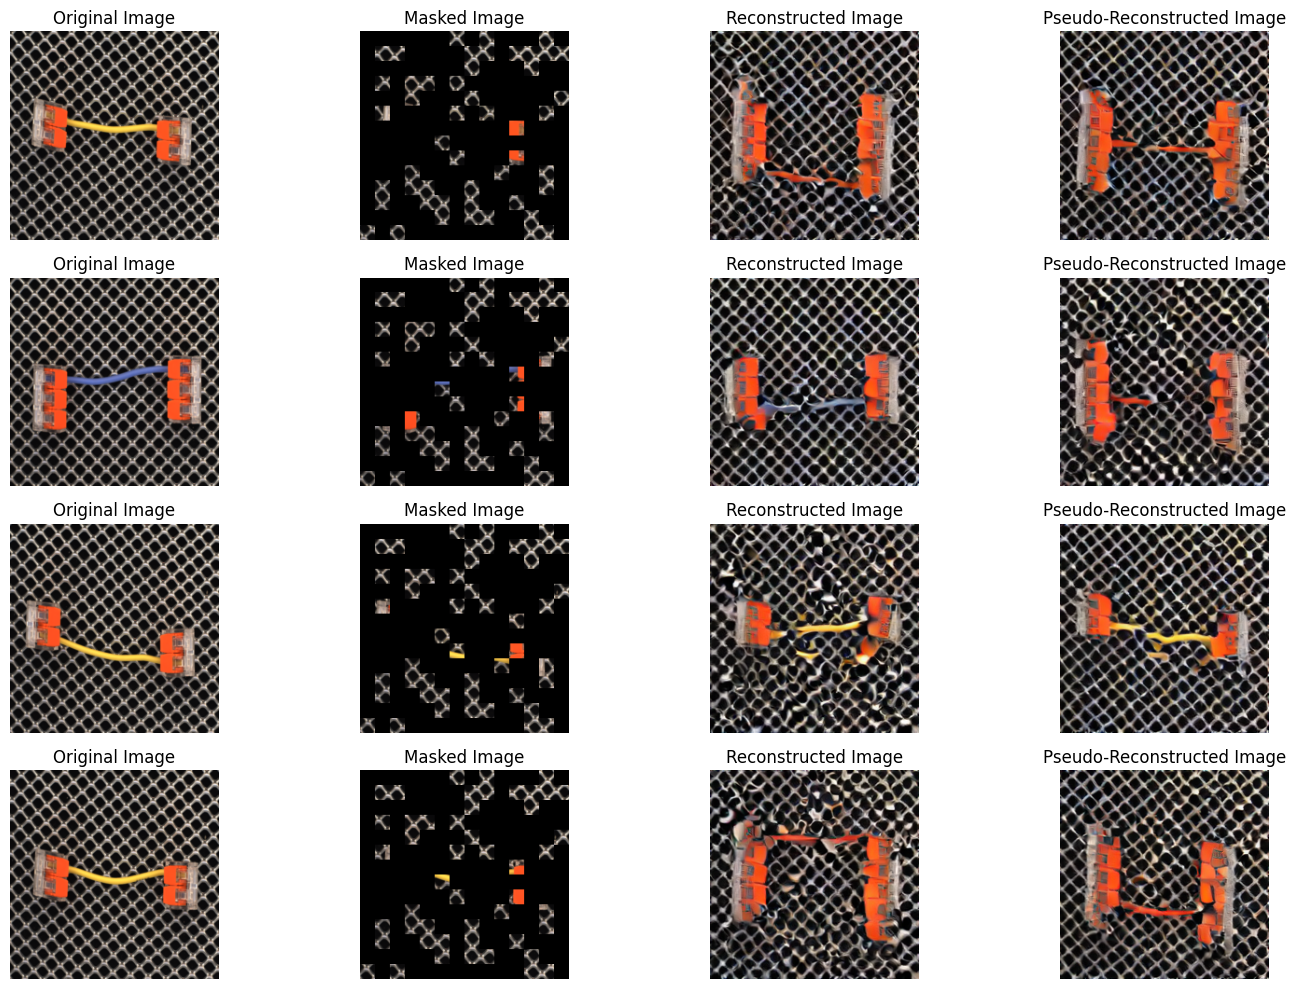

In [59]:
# Visualize the difference
pred_imgs = decode_images(pred_latents_map)  # (B*K, 3, H, W)
pseudo_pred_imgs = decode_images(pseudo_pred_latents_map)  # (B*K, 3, H, W)

mask = reshape_mask(mask).unsqueeze(1)  # (B, H, W)
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
masked_imgs = convert2image(postprocess(images) * (1 - mask))  # (B, H, W, C)
pred_imgs = convert2image(postprocess(pred_imgs)) # (B*K, H, W, C)
pred_imgs = pred_imgs.reshape(-1, num_samples, *pred_imgs.shape[1:]) # (B, K, H, W, C)  
pseudo_pred_imgs = convert2image(postprocess(pseudo_pred_imgs)) # (B*K, H, W, C)
pseudo_pred_imgs = pseudo_pred_imgs.reshape(-1, num_samples, *pseudo_pred_imgs.shape[1:]) # (B, K, H, W, C)

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for i in range(4):
    ax[i, 0].imshow(org_imgs[i])
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis('off')
    ax[i, 1].imshow(masked_imgs[i])
    ax[i, 1].set_title("Masked Image")
    ax[i, 1].axis('off')
    ax[i, 2].imshow(pred_imgs[i, 0])
    ax[i, 2].set_title(f"Reconstructed Image")
    ax[i, 2].axis('off')
    ax[i, 3].imshow(pseudo_pred_imgs[i, 0])
    ax[i, 3].set_title(f"Pseudo-Reconstructed Image")
    ax[i, 3].axis('off')

plt.tight_layout()
plt.show()

## VIsu

In [92]:
# bs = 4
# batch = {
#     "samples": [],
#     "clslabels": [],
#     "masks": []
# }
# mask_indices = []
# for bt, mi in normal_dataloader:
#     batch["samples"].append(bt["samples"][0])
#     batch["clslabels"].append(bt["clslabels"][0])
#     batch["masks"].append(bt["masks"][0])
#     mask_indices.append(mi[0])
#     if len(batch["samples"]) == bs:
#         break

# batch["samples"] = torch.stack(batch["samples"])
# batch["clslabels"] = torch.stack(batch["clslabels"])
# batch["masks"] = torch.stack(batch["masks"])
# mask_indices = torch.stack(mask_indices)

batch, mask_indices = next(iter(normal_dataloader))
# ensure same mask for all samples
mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

mask = indices_to_mask(mask_indices, model.num_patches)
mask = mask.to(device)

mask_indices = mask_indices.to(device)
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)
gt_masks = batch["masks"]  # (B, 1, H, W)

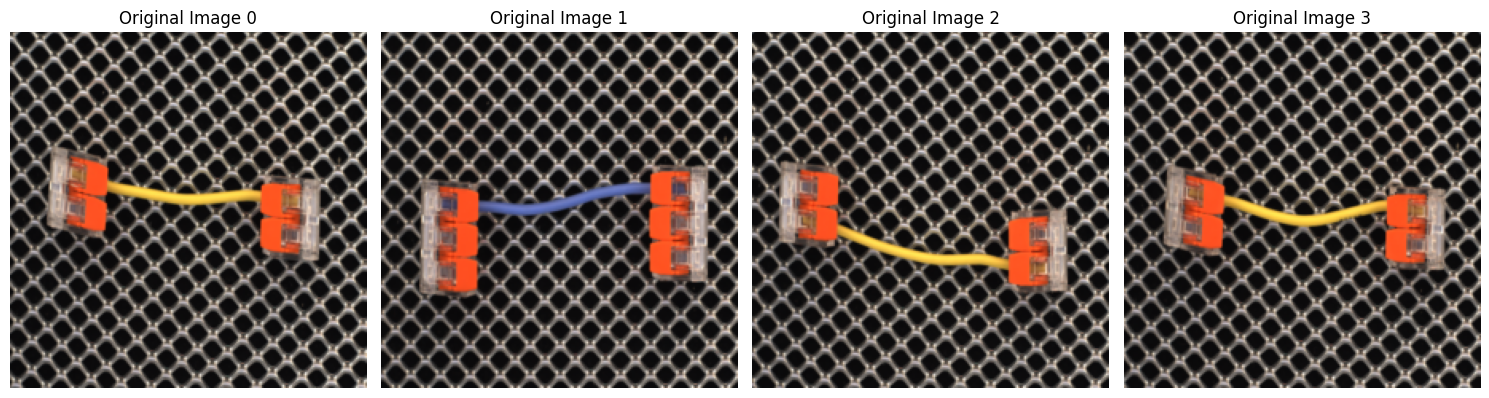

In [93]:
# Show original images
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
fig, ax = plt.subplots(1, bs, figsize=(15, 5))
for i in range(bs):
    ax[i].imshow(org_imgs[i])
    ax[i].set_title(f"Original Image {i}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [94]:
# 1. MIM Prediction
with torch.no_grad():
    latents = encode_images(images)
    outputs = model.masked_forward(latents, mask)  # (B)
    cond, target = outputs['preds'], outputs['targets']  # (B, M, c*p*p)

# Set target latents to 0-th sample
latents = torch.stack([latents[0] for _ in range(bs)])  # (B, N, c)
target = torch.stack([target[0] for _ in range(bs)])  # (B, M, c*p*p)
noised_targets, org_targets = perturb(target, t)  # (B*K, M, c*p*p)

# Denoising on masked tokens
preds = denoising(noised_targets, t, labels, cond, mask_indices)  # (B*K, M, c*p*p)
mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
latents = rearrange(latents, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', h=mim_in_sh[1], w=mim_in_sh[2], p1=patch_size, p2=patch_size)
latents = latents.repeat_interleave(num_samples, dim=0)  # (B*K, N, c)
pred_latents = latents.clone()
pred_latents[torch.arange(len(pred_latents)).unsqueeze(1), mask_indices] = preds  # (B*K, N, c)
pred_latents_map = rearrange(pred_latents, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)

In [95]:
pred_imgs = decode_images(pred_latents_map)  # (B*K, 3, H, W)
mask = reshape_mask(mask).unsqueeze(1)  # (B, H, W)
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
masked_imgs = convert2image(postprocess(images) * (1 - mask))  # (B, H, W, C)
pred_imgs = convert2image(postprocess(pred_imgs)) # (B*K, H, W, C)
pred_imgs = pred_imgs.reshape(-1, num_samples, *pred_imgs.shape[1:]) # (B, K, H, W, C)  

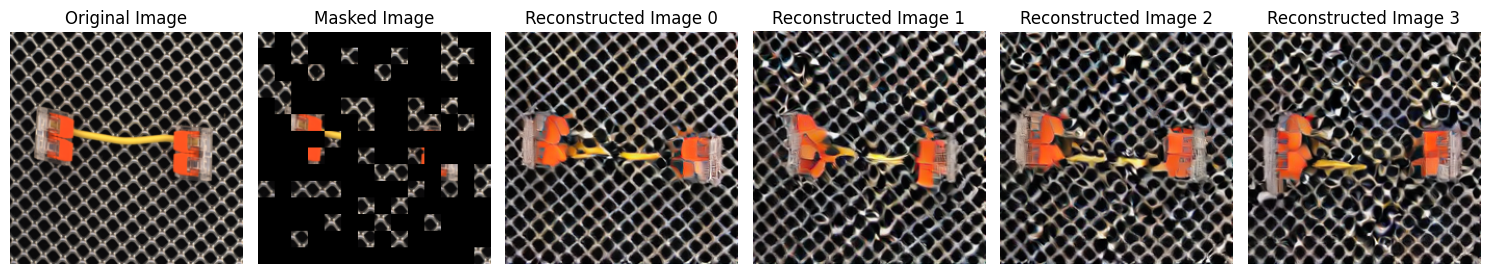

In [96]:
# Plot reconstruction
org_img = org_imgs[0]
masked_img = masked_imgs[0]
pred_img = pred_imgs[:, 0]  # (B, H, W, C), extract 0-th sample

fig, ax = plt.subplots(1, 2 + num_samples, figsize=(15, 5))
ax[0].imshow(org_img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(masked_img)
ax[1].set_title("Masked Image")
ax[1].axis('off')
ax[2].imshow(pred_img[0])
ax[2].set_title("Reconstructed Image 0")
ax[2].axis('off')
for i in range(num_samples-1):
    ax[3 + i].imshow(pred_img[i+1])
    ax[3 + i].set_title(f"Reconstructed Image {i+1}")
    ax[3 + i].axis('off')

plt.tight_layout()
plt.show()